# CASO PRACTICO 4 - API connection and market analysis
En este caso práctico realizaremos un análisis del mercado de parlantes portátiles, más precisamente de tres marcas que compiten en el: JBL, Phillips y Noga. Es de nuestro interés conocer el posicionamiento de ellas para desarrollar una política de precios competitiva. Para el desarrollo partiremos de la información brindada por la API publica de MELI (Mercado Libre - https://developers.mercadolibre.com.ar/ ). Realizaremos la ingesta, transformación y limpieza (ETL), enriqueceremos los datos (agregando metadata) y posteriormente, los visualizaremos para sacar conclusiones de negocio.


In [1]:
# Importo librerias necesarias
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import requests
from datetime import date
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dispositivos a comparar
# ETL de datos
# Lista de productos 1 => parlante jbl portatil
Disp_0 = 'parlante%20jbl%20portatil'
# Lista de productos 2 => parlante noga portatil
Disp_1 = 'parlante%20noga%20portatil'
# Lista de productos 3 => parlante philips portatil
Disp_2 = 'parlante%20philips%20portatil'

# URLs pre-determinadas por la documentacion de MELI
# Para las listas de productos:
Url_pre = 'https://api.mercadolibre.com/sites/MLA/search?q='
Url_post = '&limit=50#json'

# Para las publicaciones:
Url_generic = 'https://api.mercadolibre.com/items?ids='

In [3]:
# Genero un array con las listas de productos
array_lists =    np.array([ Url_pre + Disp_0 + Url_post, 
                            Url_pre + Disp_1 + Url_post,
                            Url_pre + Disp_2 + Url_post ])

Las URLs fueron definidas gracias a la documentación de MELI. De manera resumida el principio de funcionamiento es el siguiente: Con Url_pre y Url_post, y seleccionando el Disp formo la URL del primer GET. Realizo el primer request a la API. Ella me devuelve un listado de publicaciones que matchean. Posteriormente con la URL_generic puedo realizar un segundo request y acceder a cada uno de manera particular para encontrar información más detallada de las publicaciones y los productos.

In [4]:
# Definimos el df
df_products = pd.DataFrame()

# Recorremos el array de listas
for list in array_lists:
  
    # Ejecutamos peticion para traer lista
    response_json = requests.get( list )
    
    # Verificamos primero si la peticion se realizo correctamente
    if response_json.status_code == 200:
        response_json = response_json.json()

        print('--CARGANDO LISTA DE PRODUCTOS--')

        # Recorro las listas de productos
        for product in response_json['results']:

            # Guardamos la informacion relevante de la publicacion
            id                     = product['id']
            title                  = product['title']
            seller_sales           = product['seller']['seller_reputation']['transactions']['completed']
            seller_rating_positive = product['seller']['seller_reputation']['transactions']['ratings']['positive']
            seller_rating_negative = product['seller']['seller_reputation']['transactions']['ratings']['negative']
            price                  = product['price']
            sold_quantity          = product['sold_quantity']
            available_quantity     = product['available_quantity']
            district               = product['address']['city_name']

            # Ejecutamos la request para la publicacion, en ella conseguiremos informacion detallada de ellos
            Url_prod = Url_generic + id
            response_json_product = requests.get( Url_prod )

            # Verificamos primero si la peticion se realizo correctamente
            if response_json_product.status_code == 200:
                response_json_product = response_json_product.json()

                # Limpiamos los valores anteriores para evitar que de duplique erroneamente la informacion
                battery_duration = None
                brand            = None
                color            = None
                weight           = None
                power            = None
                portable         = None
                distortion       = None
                waterproof       = None

                # Revisamos los atributos y asignamos los matcheados
                for attribute in response_json_product[0]['body']['attributes']:
                    if attribute['id'] == 'BATTERY_AUTONOMY':
                        battery_duration = attribute['value_name']
                    if attribute['id'] == 'BRAND':
                        brand = attribute['value_name']
                    if attribute['id'] == 'COLOR':
                        color = attribute['value_name']
                    if attribute['id'] == 'WEIGHT':
                        weight = attribute['value_name']
                    if attribute['id'] == 'POWER_OUTPUT_RMS':
                        power = attribute['value_name']
                    if attribute['id'] == 'IS_PORTABLE':
                        portable = attribute['value_name']
                    if attribute['id'] == 'DISTORTION':
                        distortion = attribute['value_name']
                    if attribute['id'] == 'IS_WATERPROOF':
                        waterproof = attribute['value_name']
                    if attribute['id'] == 'ITEM_CONDITION':
                        item_cond = attribute['value_name']
                    if attribute['id'] == 'MODEL':
                        model = attribute['value_name']

                # Solo tomamos la parte del date (XXXX-XX-XX)
                registration_date      = response_json_product[0]['body']['date_created'][0:10]

                # Guardamos en el df la informacion de la publicacion
                df_products = df_products.append({'title'                  : title ,
                                                  'seller_sales'           : seller_sales ,
                                                  'seller_rating_positive' : seller_rating_positive ,
                                                  'seller_rating_negative' : seller_rating_negative ,
                                                  'price'                  : price ,
                                                  'sold_quantity'          : sold_quantity ,
                                                  'available_quantity'     : available_quantity ,
                                                  'battery_duration'       : battery_duration ,
                                                  'district'               : district ,
                                                  'battery_duration'       : battery_duration ,
                                                  'brand'                  : brand ,
                                                  'color'                  : color ,
                                                  'weight'                 : weight ,
                                                  'power'                  : power ,
                                                  'portable'               : portable ,
                                                  'item_cond'              : item_cond ,
                                                  'distortion'             : distortion ,
                                                  'model'                  : model ,
                                                  'registration_date'      : registration_date ,
                                                  'waterproof'             : waterproof } , ignore_index=True)
            else:
                print('Error de peticion.')
                print( response_json_product.status_code )
    else:
        print('Error de peticion.')
        print( response_json_product.status_code )
                    
                    

--CARGANDO LISTA DE PRODUCTOS--
--CARGANDO LISTA DE PRODUCTOS--
--CARGANDO LISTA DE PRODUCTOS--


In [5]:
# Revisamos que la carga sea correcta
df_products.head(5)

,available_quantity,battery_duration,brand,color,distortion,district,item_cond,model,portable,power,price,registration_date,seller_rating_negative,seller_rating_positive,seller_sales,sold_quantity,title,waterproof,weight
0,58.0,5 h,JBL,Midnight black,None,Capital Federal,Nuevo,Go 2,Sí,3.1 W,4200.00,2019-11-14,0.02,0.96,44074.0,2113.0,Parlante Jbl Go 2 Portátil Con Bluetooth Midni...,Sí,184 g
1,11.0,20 h,JBL,Squad,1 %,Capital Federal,Nuevo,Charge 4,Sí,30 W,21199.00,2020-11-16,0.02,0.96,44074.0,25.0,Parlante Jbl Charge 4 Portátil Con Bluetooth S...,Sí,965 g
2,730.0,12 h,JBL,Black matte,None,Palermo Soho,Nuevo,Flip 5,Sí,20 W,12673.00,2021-07-23,0.02,0.97,36072.0,166.0,Parlante Jbl Flip 5 Portátil Con Bluetooth Bla...,Sí,540 g
3,188.0,5 h,JBL,Red,None,Florida Oeste,Nuevo,Go 3,Sí,4.2 W,6047.79,2021-07-15,0.01,0.98,8980.0,7.0,Parlante Jbl Go 3 Portátil Con Bluetooth Red,Sí,0.209 kg
4,9.0,5 h,JBL,Apple red,None,Ramos Mejia,Nuevo,JR Pop,Sí,3 W,4437.00,2021-07-15,0.00,0.99,9542.0,1.0,Parlante Jbl Jr Pop Portátil Con Bluetooth App...,Sí,121.2 g


Una vez realizada la ingesta debemos analizar la información para transformarla, limpiarla y formatearla. En este caso, por ejemplo, tenemos “weight” en gramos y kilogramos. Este es un paso clave previo a la visualización. 

In [6]:
# Formatemos power como un float
array_power                     = df_products['power'].str.split(expand=True)
df_products['power']            = array_power[0].astype(float)

# Formatemos battery_duration como un float
array_battery                   = df_products['battery_duration'].str.split(expand=True)
df_products['battery_duration'] = array_battery[0].astype(float)

# Aplicamos en weight la correccion para los valores en kg normalizando a g y lo formateamos como un float.
array_weight                    = df_products['weight'].str.split(expand=True)
array_weight[0]                 = array_weight[0].astype(float)
df_products['weight']           = array_weight.apply( lambda array_weight: array_weight[0]*1000 if array_weight[1]=='kg' else array_weight[0], axis=1 )

# Igualamos los valores de noganet y noga a noga. Son de la misma empresa de tecnologia.
df_products['brand']            = df_products['brand'].str.replace('Noganet','Noga')


In [7]:
# Reviso que la transformacion sea suficiente
df_products.head(5)

,available_quantity,battery_duration,brand,color,distortion,district,item_cond,model,portable,power,price,registration_date,seller_rating_negative,seller_rating_positive,seller_sales,sold_quantity,title,waterproof,weight
0,58.0,5.0,JBL,Midnight black,None,Capital Federal,Nuevo,Go 2,Sí,3.1,4200.00,2019-11-14,0.02,0.96,44074.0,2113.0,Parlante Jbl Go 2 Portátil Con Bluetooth Midni...,Sí,184.0
1,11.0,20.0,JBL,Squad,1 %,Capital Federal,Nuevo,Charge 4,Sí,30.0,21199.00,2020-11-16,0.02,0.96,44074.0,25.0,Parlante Jbl Charge 4 Portátil Con Bluetooth S...,Sí,965.0
2,730.0,12.0,JBL,Black matte,None,Palermo Soho,Nuevo,Flip 5,Sí,20.0,12673.00,2021-07-23,0.02,0.97,36072.0,166.0,Parlante Jbl Flip 5 Portátil Con Bluetooth Bla...,Sí,540.0
3,188.0,5.0,JBL,Red,None,Florida Oeste,Nuevo,Go 3,Sí,4.2,6047.79,2021-07-15,0.01,0.98,8980.0,7.0,Parlante Jbl Go 3 Portátil Con Bluetooth Red,Sí,209.0
4,9.0,5.0,JBL,Apple red,None,Ramos Mejia,Nuevo,JR Pop,Sí,3.0,4437.00,2021-07-15,0.00,0.99,9542.0,1.0,Parlante Jbl Jr Pop Portátil Con Bluetooth App...,Sí,121.2


Este proceso fue simplificado, pero para llevarlo adelante de manera es necesario realizar un análisis exploratorio previo y posterior a la transformación validando que la llegada de los datos nuevos y su transformación este contemplada en nuestras reglas. 
También podemos enriquecer con metadatos nuestra tabla de datos.


In [8]:
# Agregamos columna con la fecha de hoy
df_products['date_today']             = date.today().strftime("%Y-%m-%d")

# Formateamos las columnas date
df_products['registration_date']      = pd.to_datetime(df_products['registration_date'])
df_products['date_today']             = pd.to_datetime(df_products['date_today'])

# Conociendo hace cuantos dias esta activa la publicacion y la cantidad de productos vendidos en ella puedo sacar la cantidad de productos vendidos al dia
# en cada una de ellas
df_products['diff_days']               = df_products['date_today'] - df_products['registration_date'] 
df_products['sold_quantity/diff_days'] = df_products['sold_quantity'] / df_products['diff_days'].dt.days

Para la visualización resulta importante definir previamente que quiero chequear. Jugar con los datos y hacerse preguntas es un buen comienzo. 

¿En qué rango de precios se encuentran los productos? ¿Cual posee mejores features?

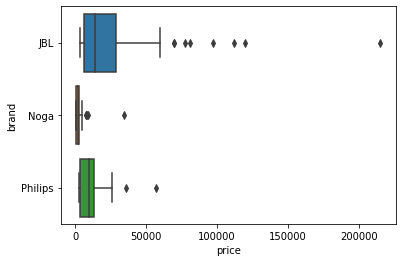

In [9]:
 # Comienzo analizando el segmento de precios en los que se encuentran las marcas
 ax = sns.boxplot(x="price", y="brand", data=df_products)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


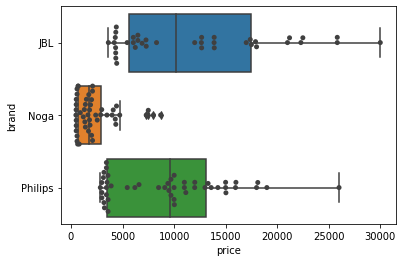

In [10]:
# En primer lugar podemos ver como JBL posee una gama de precios mucho mas amplia, llegando a alcanzar los 120k en algunos productos.
# Para visualizar de manera mas precisa vamos a centrarnos en los parlates de costo menor a 30000, quitando outliers
df_products_prices = df_products.loc[(df_products['price'] < 30000)]

# Realizamos el boxplot
ax = sns.boxplot(x="price", y="brand", data=df_products_prices)
ax = sns.swarmplot(x="price", y="brand", data=df_products_prices, color=".25")

Aquí podemos ver como Noga se posiciona como un producto low cost frente a sus competidores. Phillips y JBL luchan en el segmento medio y superior. Phillips parece querer disputarle el mercado a JBL, poniendo sus precios levemente por debajo.

Text(0.5, 1.0, 'Weight (g)')

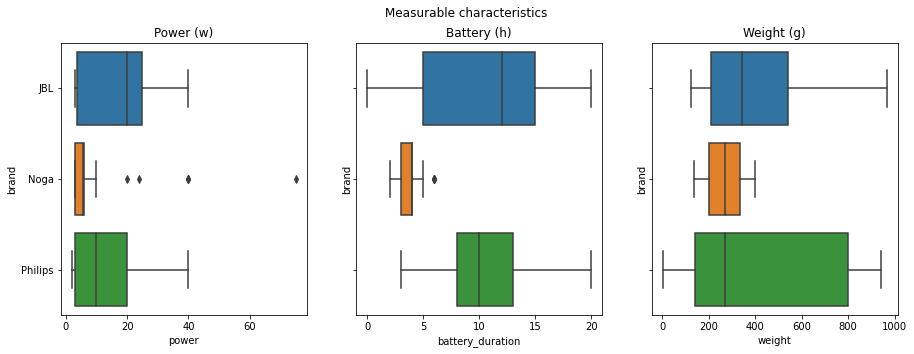

In [11]:
# Comparamos de caracterisicas medibles de manera numerica
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Measurable characteristics')

# Power
# Quitamos los outliers
df_products_power = df_products.loc[(df_products['power'] < 100)]
sns.boxplot(ax=axes[0], x="power", y="brand", data=df_products_power)
axes[0].set_title("Power (w)")

# Battery
sns.boxplot(ax=axes[1], x="battery_duration", y="brand", data=df_products)
axes[1].set_title("Battery (h)")

# Weight
# Quitamos los outliers
df_products_weight = df_products.loc[(df_products['weight'] < 2000)]
sns.boxplot(ax=axes[2], x="weight", y="brand", data=df_products_weight)
axes[2].set_title("Weight (g)")

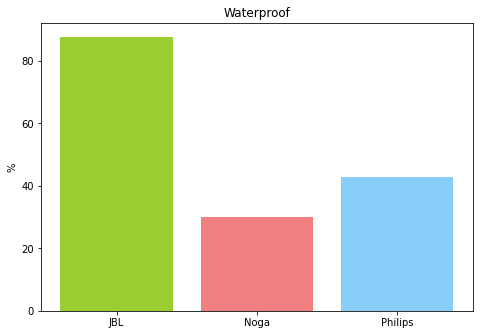

In [12]:
# Resistencia al agua
# Separamos en df por marca
df_products_JBL     = df_products.loc[(df_products['brand'] == 'JBL')]
df_products_Noga    = df_products.loc[(df_products['brand'] == 'Noga')]
df_products_Philips = df_products.loc[(df_products['brand'] == 'Philips')]

# Calculamos el promedio de los productos resistencies al agua por marca
df_products_JBL_waterproof     = df_products_JBL['waterproof'].dropna()
prom_waterproof_JBL            = ( df_products_JBL[df_products_JBL['waterproof']         == 'Sí'].shape[0] / df_products_JBL_waterproof.shape[0] ) * 100

df_products_Noga_waterproof    = df_products_Noga['waterproof'].dropna()
prom_waterproof_Noga           = ( df_products_Noga[df_products_Noga['waterproof']       == 'Sí'].shape[0] / df_products_Noga_waterproof.shape[0] ) * 100

df_products_Philips_waterproof = df_products_Philips['waterproof'].dropna()
prom_waterproof_Philips        = ( df_products_Philips[df_products_Philips['waterproof'] == 'Sí'].shape[0] / df_products_Philips_waterproof.shape[0] ) * 100

# Realizamos un grafico de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
brands = ['JBL','Noga','Philips']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
prom_waterproof = [prom_waterproof_JBL , prom_waterproof_Noga , prom_waterproof_Philips]
ax.bar(brands,prom_waterproof, color=colors)
plt.title('Waterproof')
plt.ylabel('%')
plt.show()

Al compararlos comenzamos a validar nuestra primera premisa. Noga se posiciona como un producto económico, de menores prestaciones. JBL parecería ser la marca líder logrando la mejor relacion power- battery-weight y con prácticamente un 90% de sus productos resistentes al agua. Por su parte Phillips logra en algunos puntos acercarse a JBL pero se posiciona más bien como un producto intermedio, de menor categoría y costo que el líder.

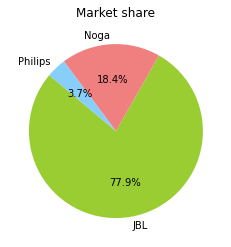

In [13]:
# Calculamos la cantidad de productos vendidos promedio por marca
prom_solddays_JBL     = df_products_JBL['sold_quantity/diff_days'].sum()
prom_solddays_Noga    = df_products_Noga['sold_quantity/diff_days'].sum()
prom_solddays_Philips = df_products_Philips['sold_quantity/diff_days'].sum()

# Realizamos el grafico de torta
labels = ['JBL','Noga','Philips']
prom_solddays = [prom_solddays_JBL, prom_solddays_Noga, prom_solddays_Philips]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie( prom_solddays, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140 )
plt.title('Market share')
plt.show()

De la muestra tomada, podemos concluir que la mayoría de los portátiles vendidos son de JBL. Noga, luce fuerte en su segmento y acumula (aproximadamente) el 20% de las ventas de portátiles. Por su parte la estrategia de Phillips parecería no estar dando tan buenos resultados frente a JBL.

**Conclusión**

En este caso comprendimos un poco más sobre cómo desarrollar un proceso ETL y su importancia. Llevar adelante de manera minuciosa esta actividad nos facilitara enormemente la visualización posterior. También, nos garantizara cierta certidumbre de que lo observado es correcto.

Por su parte, el enriquecimiento de datos nos permitió inferir la cantidad de productos vendidos por marca. 

Las visualizaciones nos permitieron comprender los datos de una manera más intuitiva y amigable.

